# CuteSmileyBert : a toy transformer for SMILES strings

Molecules being 3-dimensional objects with complex physical interactions, it is inevitable that much information will be lost when trying to generate typical ring signatures or manual featurizations. Transformers offer a solution to that by creating rich encodings of the information, and in this notebook we'll train a very small and inexpensive one, to see if it works.

CuteSmileyBERT is a model trained on masked SMILES strings, with a 150-token context length and 5 million parameters. It was trained on a Nvidia A100 for 20 minutes in Google Colab (this notebook comes from Colab). It is now available for donwload on Hugging Face Hub. 

In [1]:
!git clone https://github.com/Orbliss/Cheminformatics_molecule_property_project.git

Cloning into 'Cheminformatics_molecule_property_project'...
remote: Enumerating objects: 160, done.
remote: Counting objects: 100% (160/160), done.
remote: Compressing objects: 100% (109/109), done.
remote: Total 160 (delta 80), reused 110 (delta 45), pack-reused 0 (from 0)
Receiving objects: 100% (160/160), 1.26 MiB | 33.11 MiB/s, done.
Resolving deltas: 100% (80/80), done.


In [2]:
%cd Cheminformatics_molecule_property_project/regression

/content/Cheminformatics_molecule_property_project/regression


In [3]:
import sys
sys.path.append("/content/Cheminformatics_molecule_property_project")

In [4]:
import re
import random
import os
import json
import math
from pathlib import Path

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from src.download_dataset import download_datasets, extract_files

ROOT_DIR = Path("../")
DATA_DIR = Path(ROOT_DIR, "data")

# We start by downloading the dataset and opening it with Pandas
smiles_datasets = {
    'SMILES_Big_Dataset.csv.zip': 'https://www.kaggle.com/api/v1/datasets/download/yanmaksi/big-molecules-smiles-dataset'
}

download_datasets(smiles_datasets)
extract_files(smiles_datasets)

filename = list(smiles_datasets.keys())[0]
file_path = Path(DATA_DIR, filename)
df = pd.read_csv(file_path)

Data directory: /content/Cheminformatics_molecule_property_project/data
Téléchargement de SMILES_Big_Dataset.csv.zip...


/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.kaggle.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'storage.googleapis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(
SMILES_Big_Dataset.csv.zip: 100%|██████████| 289k/289k [00:00<00:00, 456kB/s]


SMILES_Big_Dataset.csv.zip téléchargé et enregistré sous /content/Cheminformatics_molecule_property_project/data/SMILES_Big_Dataset.csv.zip
Extraction de SMILES_Big_Dataset.csv.zip...


Extracting SMILES_Big_Dataset.csv.zip: 100%|██████████| 1/1 [00:00<00:00, 104.85it/s]


SMILES_Big_Dataset.csv.zip extrait dans /content/Cheminformatics_molecule_property_project/data/SMILES_Big_Dataset.csv


In [5]:
# This is the column that we are interested in
smiles_list = df["SMILES"].to_list()

df["SMILES"].head()

,SMILES
0,O=S(=O)(Nc1cccc(-c2cnc3ccccc3n2)c1)c1cccs1
1,O=c1cc(-c2nc(-c3ccc(-c4cn(CCP(=O)(O)O)nn4)cc3)...
2,NC(=O)c1ccc2c(c1)nc(C1CCC(O)CC1)n2CCCO
3,NCCCn1c(C2CCNCC2)nc2cc(C(N)=O)ccc21
4,CNC(=S)Nc1cccc(-c2cnc3ccccc3n2)c1


In [6]:
# List of SMILES tokens that we're going to separate into lists
SMILES_REGEX = re.compile(
    r"(\%\d\d|Br|Cl|Si|Na|Ca|Li|@@?|=|#|\(|\)|\.|\[|\]|\/|\\|:|~|\+|\-|\d|[A-Za-z])"
)

# Special tokens to encode different types of empty or masked spaces
MASK_TOKEN = "<MASK>"
PAD_TOKEN = "<PAD>"
BOS_TOKEN = "<BOS>"
EOS_TOKEN = "<EOS>"
UNK_TOKEN = "<UNK>"
MASK_TOKEN = "<MASK>"

SPECIAL_TOKENS = [PAD_TOKEN, BOS_TOKEN, EOS_TOKEN, UNK_TOKEN, MASK_TOKEN]

# This is the max padded length of a "sentence"
MAX_LEN = 150

# Returns a list containing each individual token
def tokenize_smiles(smiles: str) -> list[str]:
    return SMILES_REGEX.findall(smiles)

# Returns two dictionaries mapping unique tokens to integer indexes
def build_vocab(smiles_list: list[str]) -> tuple[dict[str, int], dict[int, str]]:
    # Create a set of tokens (sets don't contain repeated values)
    tokens = set(SPECIAL_TOKENS)
    for s in smiles_list:
        tokens.update(tokenize_smiles(s))
    # Sort all tokens, make a list, and map each token to its index
    vocab = {tok: i for i, tok in enumerate(sorted(tokens))}
    # Reverse dictionary that maps indexes to tokens
    inv_vocab = {i: tok for tok, i in vocab.items()}
    return vocab, inv_vocab

# Turn smiles string into fixed-length list of token IDs, with special tokens
def encode_smiles(
    smiles: str,
    vocab: dict[str, int],
    max_len: int=MAX_LEN
) -> list[int]:
    # Adds start and end tokens to the SMILES list
    tokens = [BOS_TOKEN] + tokenize_smiles(smiles) + [EOS_TOKEN]
    # Creates a list with the integer IDs of each token
    token_ids = [vocab.get(t, vocab[UNK_TOKEN]) for t in tokens]
    # Create a vector of length max_len and fill it with pad tokens until the end
    token_ids = token_ids[:max_len] + [vocab[PAD_TOKEN]] * (max_len - len(token_ids))
    return token_ids

# Get a list of token IDs as input, replace some by <MASK>
def mask_tokens(
    input_ids: list[int],
    vocab: dict[str, int],
    mask_prob: float=0.15
) -> tuple[list[int], list[int]]:
    # Two copies of ID vector so we can mask one and predict the other
    input_ids = input_ids.clone()
    labels = input_ids.clone()

    # Get the IDs of mask and pad tokens, plus context size
    mask_token_id = vocab[MASK_TOKEN]
    pad_token_id = vocab[PAD_TOKEN]
    vocab_size = len(vocab)

    # Do not mask padding tokens
    maskable = input_ids != pad_token_id
    masked_indices = torch.bernoulli(torch.full(input_ids.shape, mask_prob)).bool() & maskable
    labels[~masked_indices] = -100

    # Replace 80% of tokens with <MASK>
    replace_mask = torch.bernoulli(torch.full(input_ids.shape, 0.8)).bool() & masked_indices
    input_ids[replace_mask] = mask_token_id

    # Replace 10% with random token
    random_mask = torch.bernoulli(torch.full(input_ids.shape, 0.1)).bool() & masked_indices & ~replace_mask
    random_tokens = torch.randint(vocab_size, input_ids.shape, dtype=torch.long)
    input_ids[random_mask] = random_tokens[random_mask]

    # 10% keep unchanged (no-op for the rest)
    return input_ids, labels

In [7]:
# Dataset class with input-target pairs for masked vs original strings
class SMILESMaskedDataset(torch.utils.data.Dataset):
    # Creates class attribute "data", a list of every encoded SMILES string
    def __init__(
        self,
        smiles_list: list[str],
        vocab: dict[str, int],
        max_len: int=150
    ) -> None:
        self.vocab = vocab
        self.max_len = max_len
        self.data = [encode_smiles(s, vocab, max_len) for s in smiles_list]

    # Length method, required by pytorch
    def __len__(self) -> int:
        return len(self.data)

    # Returns a pair of masked and unmasked encodings in Tensor form
    def __getitem__(self, idx:int) -> tuple[list[int], list[int]]:
        input_ids = torch.tensor(self.data[idx], dtype=torch.long)
        masked_input, labels = mask_tokens(input_ids, self.vocab)
        return masked_input, labels

In [8]:
# We're going to wrap our model inside a Hugging Face Transformers class
# This gives us a standard definition that can be easily pushed and pulled
# It's all still PyTorch under the hood, just with a Hugging Face wrapper
from transformers import PretrainedConfig, PreTrainedModel

class CuteSmileyBERTConfig(PretrainedConfig):
    model_type = "CuteSmileyBERT"
    def __init__(self, vocab_size=100, d_model=256, nhead=8, num_layers=6, dim_feedforward=1024, dropout=0.1, max_len=150, **kwargs):
        super().__init__(**kwargs)
        self.vocab_size = vocab_size
        self.d_model = d_model
        self.nhead = nhead
        self.num_layers = num_layers
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        self.max_len = max_len

class CuteSmileyBERT(PreTrainedModel):
    config_class = CuteSmileyBERTConfig
    def __init__(self, config):
        # Intialize the nn.Module parent class, needed for proper inheritance
        super().__init__(config)

        # Set the input max_len to a class attribute
        self.max_len = config.max_len

        # This defines a method for embeddings, which will be our input representation
        # It effectively creates a weight matrix of shape [vocab_size, d_model]
        # The weights are initialized at random and will be learnt over time
        self.embed = nn.Embedding(config.vocab_size, config.d_model)
        # We will also be using positional embeddings, which will be added to the tokens'
        # They will be learnt based solely on integer positions, with no information on the tokens
        self.pos_embed = nn.Embedding(config.max_len, config.d_model)

        # Defines a single transfomer layer, with attention and feedforward/MLP layers
        # Each later contains nhead attention heads, and a ff with dimensions dim_feedforward
        # Dropout prevents overfitting by randomly setting 10% of attention coefficients to 0
        # Batch-first means that the input shape is given as [batch, seq_len, d_model]
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=config.d_model, nhead=config.nhead,
            dim_feedforward=config.dim_feedforward, dropout=config.dropout, batch_first=True
        )

        # This attribute defines the model's main structure, a sequence of num_layers encoder layers
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=config.num_layers)

        # This is the final layer, a simple linear MLP which maps the embeddings to token logits
        # The input dimension is d_model, and the output is vocab_size (1-hot encoded vector)
        self.lm_head = nn.Linear(config.d_model, config.vocab_size)

    # This is a single training cycle.
    def forward(
        self,
        input_ids: list[int],
        return_embeddings: bool=False
    ):
        # Get batch size and sequence length, used for positional encodings
        batch_size, seq_len = input_ids.shape

        # Creates a 1D tensor which simply contains the int positions of each token
        positions = torch.arange(seq_len, device=input_ids.device).unsqueeze(0)
        # Our positions tensor is embedded, without any information on the actual tokens
        pos_embeddings = self.pos_embed(positions)
        # The positional embeddings are then summed to the token embeddings
        x = self.embed(input_ids) + pos_embeddings

        # We pass the embeddings through the encoder block
        x = self.encoder(x)
        # The linear layer outputs logits
        logits = self.lm_head(x)
        if return_embeddings:
            return x
        return logits

In [9]:
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Current device:", torch.cuda.current_device())
    print("Device name:", torch.cuda.get_device_name(torch.cuda.current_device()))
else:
    print("No CUDA device detected.")

CUDA available: True
Current device: 0
Device name: NVIDIA A100-SXM4-80GB


In [11]:
# Train the model

vocab, inv_vocab = build_vocab(smiles_list)

dataset = SMILESMaskedDataset(smiles_list, vocab, max_len=150)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

def train_model(
    model:PreTrainedModel,
    model_name:str
):

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    criterion = nn.CrossEntropyLoss(ignore_index=-100)
    optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

    EARLY_STOP_THRESH = 5

    losses = []
    perplexities = []
    best_perplexity = 200
    early_stop_counter = 0

    print("Beginning training... ")
    for epoch in range(300):
        total_loss = 0.0
        batch_count = 0
        for masked_input, labels in loader:
            masked_input = masked_input.to(device)
            labels = labels.to(device)
            optimizer.zero_grad()
            logits = model(masked_input)
            loss = criterion(logits.view(-1, len(vocab)), labels.view(-1))
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            batch_count += 1
        avg_loss = total_loss / batch_count
        perplexity = math.exp(avg_loss)
        losses.append(loss.item())
        perplexities.append(perplexity)
        if perplexity < best_perplexity:
            best_perplexity = perplexity
            early_stop_counter = 0
        else:
            early_stop_counter += 1
            if early_stop_counter == EARLY_STOP_THRESH:
                print(f"Stopping training at epoch {epoch}")
                break

    # Save in Hugging Face format
    model.save_pretrained(f"./{model_name}")

    # Push to Hugging Face Hub
    model.push_to_hub(f"marcosbolanos/{model_name}")
    config.push_to_hub(f"marcosbolanos/{model_name}")

    return losses, perplexities

config = CuteSmileyBERTConfig(
    vocab_size=len(vocab),
    d_model=256,
    nhead=8,
    num_layers=6,
    dim_feedforward=1024,
    dropout=0.1,
    max_len=150
)
model = CuteSmileyBERT(config)

trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print("Number of trainable parameters:", trainable_params)

losses4m, perplexities4m = train_model(model, "cutesmileybert-4.8m")

Number of trainable parameters: 4796454
Beginning training... 
Stopping training at epoch 151


README.md:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

Processing Files (0 / 0)      : |          |  0.00B /  0.00B            

New Data Upload               : |          |  0.00B /  0.00B            

  ...rt-4.8m/model.safetensors:   3%|2         |  557kB / 19.2MB            

No files have been modified since last commit. Skipping to prevent empty commit.


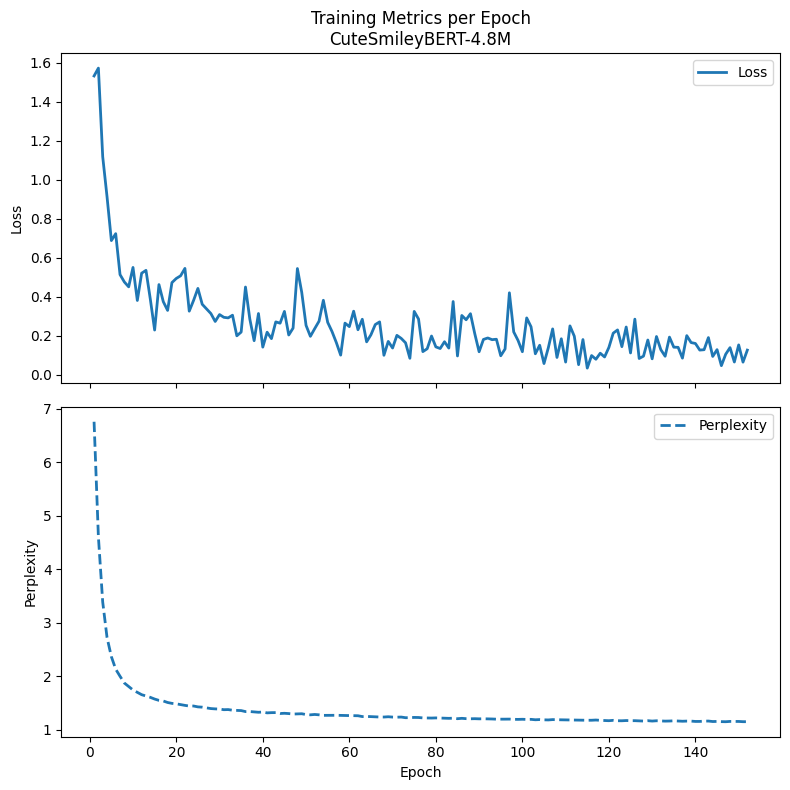

In [13]:
import matplotlib.pyplot as plt

epochs = range(1, len(losses4m) + 1)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

# Plotting loss by epoch
ax1.plot(epochs, losses4m, label="Loss", linewidth=2)
ax1.set_ylabel("Loss")
ax1.set_title(f"Training Metrics per Epoch\nCuteSmileyBERT-4.8M")
ax1.legend()

# Plotting perplexity by epoch
ax2.plot(epochs, perplexities4m, label="Perplexity", linestyle='--', linewidth=2)
ax2.set_xlabel("Epoch")
ax2.set_ylabel("Perplexity")
ax2.legend()

plt.tight_layout()
plt.show()

In [16]:
from transformers import PreTrainedTokenizer

# Finally, we're adding our tokenizer to the repos so that they can be used by other users

class SMILESTokenizer(PreTrainedTokenizer):
    def __init__(self, vocab, inv_vocab, **kwargs):
        self.vocab = vocab
        self.inv_vocab = inv_vocab
        self.pad_token = "<PAD>"
        self.unk_token = "<UNK>"
        self.bos_token = "<BOS>"
        self.eos_token = "<EOS>"
        self.mask_token = "<MASK>"
        self.special_tokens = [self.pad_token, self.unk_token, self.bos_token, self.eos_token, self.mask_token]
        super().__init__(**kwargs)
        self.add_special_tokens({
            "pad_token": self.pad_token,
            "unk_token": self.unk_token,
            "bos_token": self.bos_token,
            "eos_token": self.eos_token,
            "mask_token": self.mask_token
        })

    def get_vocab(self):
        return self.vocab

    @property
    def vocab_size(self):
        return len(self.vocab)

    def _tokenize(self, text):
        return tokenize_smiles(text)

    def _convert_token_to_id(self, token):
        return self.vocab.get(token, self.vocab[self.unk_token])

    def _convert_id_to_token(self, index):
        return self.inv_vocab.get(index, self.unk_token)

    def encode(self, text, add_special_tokens=True, max_length=150):
        tokens = self._tokenize(text)
        if add_special_tokens:
            tokens = [self.bos_token] + tokens + [self.eos_token]
        token_ids = [self._convert_token_to_id(tok) for tok in tokens]
        token_ids = token_ids[:max_length] + [self.vocab[self.pad_token]] * (max_length - len(token_ids))
        return token_ids

    def decode(self, token_ids, skip_special_tokens=True):
        tokens = [self._convert_id_to_token(i) for i in token_ids]
        if skip_special_tokens:
            tokens = [t for t in tokens if t not in self.special_tokens]
        return "".join(tokens)

    def save_vocabulary(self, save_directory, filename_prefix=None):
        vocab_file = os.path.join(save_directory, (filename_prefix or "") + "vocab.json")
        with open(vocab_file, "w") as f:
            json.dump(self.vocab, f)
        return (vocab_file,)

    @classmethod
    def from_pretrained(cls, pretrained_model_name_or_path, *inputs, **kwargs):
        vocab_file = os.path.join(pretrained_model_name_or_path, "vocab.json")
        with open(vocab_file, "r") as f:
            vocab = json.load(f)
        inv_vocab = {i: tok for tok, i in vocab.items()}
        return cls(vocab, inv_vocab, **kwargs)

# Instantiate and push to hub
smiles_tokenizer = SMILESTokenizer(vocab, inv_vocab)
smiles_tokenizer.save_pretrained("./cutesmileybert-4.8m")
smiles_tokenizer.push_to_hub("marcosbolanos/cutesmileybert-4.8m")

CommitInfo(commit_url='https://huggingface.co/marcosbolanos/cutesmileybert-50m/commit/462dd334863e4870193bb1f411516fe47ab4c7d0', commit_message='Upload tokenizer', commit_description='', oid='462dd334863e4870193bb1f411516fe47ab4c7d0', pr_url=None, repo_url=RepoUrl('https://huggingface.co/marcosbolanos/cutesmileybert-50m', endpoint='https://huggingface.co', repo_type='model', repo_id='marcosbolanos/cutesmileybert-50m'), pr_revision=None, pr_num=None)